In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
%cd /content/drive/MyDrive/Universidad/Aprendizaje Automático II/Práctica/Trabajos/FINAL/IMAGENES

/content/drive/MyDrive/AA II/NUEVO (1)


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definir transformaciones para los datos de entrenamiento y validación
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar las imágenes
    transforms.ToTensor()  # Convertir las imágenes a tensores
])

# Cargar los datos de entrenamiento y validación
dataset_entrenamiento = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train', transform=transformaciones)
dataset_validacion = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/validation', transform=transformaciones)
dataset_test = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/test', transform=transformaciones)

In [2]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Nueva capa convolucional

        # Batch Normalization para cada capa convolucional
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)  # Normalización para la nueva capa

        # MaxPooling y Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout_conv = nn.Dropout(p=0.25)  # Dropout para capas convolucionales
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout para capas densas

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Ajuste del tamaño según salida de la última capa convolucional
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)  # Salida para 7 clases

        # Batch Normalization para capas densas
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)

    def forward(self, x):
        # Pasos convolucionales con activación, normalización y pooling
        x = self.pool(F.sigmoid(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.sigmoid(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.sigmoid(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.sigmoid(self.bn4(self.conv4(x))))  # Nueva capa convolucional
        x = self.dropout_conv(x)

        # Aplanar para pasar a capas densas
        x = x.view(-1, 128 * 6 * 6)

        # Pasos densos con activación, normalización y dropout
        x = F.sigmoid(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)

        x = F.sigmoid(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)

        x = self.fc3(x)  # Sin activación final porque CrossEntropyLoss la incluye
        return x


In [4]:
def graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion):
    # Crear una figura con dos subgráficos en una fila
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar la función de pérdida en el primer subgráfico
    ax[0].plot(valores_perdida, label='Pérdida')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].set_title(f'Función de Pérdida\n LR: {lr} Batch Size: {batch_size}')
    ax[0].legend()

    # Graficar las exactitudes en el segundo subgráfico
    ax[1].plot(exactitud_entrenamiento, label='Exactitud de Entrenamiento')
    ax[1].plot(exactitud_validacion, label='Exactitud de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Exactitud')
    ax[1].set_title(f'Exactitud de Entrenamiento y Validación\n LR: {lr} Batch Size: {batch_size}')
    ax[1].legend()

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

In [5]:
def calcular_exactitud_test(modelo, dataloader_test, device):
    correctas = 0
    total = 0
    with torch.no_grad():
        modelo.eval()

        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correctas += (predicted == labels).sum().item()
        #print(f'Exactitud de el modelo con las {total} imágenes de test: {100*correctas/total}%')
    return 100*correctas/total

In [8]:
def matriz_de_confusion(modelo, dataloader_test, device):

    modelo.eval()

    # Inicializar listas para etiquetas reales y predicciones
    predicciones_totales = []
    etiquetas_reales_totales = []

    # Verificar que el dataloader_test tiene datos
    if len(dataloader_test.dataset) == 0:
        print("El conjunto de test está vacío. Verifica los datos.")
    else:
        # Bucle para obtener predicciones
        with torch.no_grad():
            for imagenes, etiquetas in dataloader_test:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                _, predicciones = torch.max(salidas, 1)
                predicciones_totales.extend(predicciones.cpu().numpy())
                etiquetas_reales_totales.extend(etiquetas.cpu().numpy())

    # Comprobar si se obtuvieron predicciones
    if len(etiquetas_reales_totales) > 0 and len(predicciones_totales) > 0:
        # Imprimir el reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(etiquetas_reales_totales, predicciones_totales, digits=4))

        # Crear la matriz de confusión
        etiquetas_unicas = sorted(set(etiquetas_reales_totales))  # Identificar las clases presentes
        matriz_confusion_test = confusion_matrix(etiquetas_reales_totales, predicciones_totales, labels=etiquetas_unicas)

        # Visualizar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_unicas, yticklabels=etiquetas_unicas)
        plt.xlabel('Predicciones')
        plt.ylabel('Etiquetas Reales')
        plt.title('Matriz de Confusión del Conjunto de Test')
        plt.show()

        # Mostrar las clases presentes
        clases_presentes = set(etiquetas_reales_totales)
        print(f"Clases presentes en el conjunto de test: {clases_presentes}")
    else:
        print("No se encontraron datos válidos para generar predicciones o etiquetas.")


Entrenando con lr=0.005, batch_size=32, epochs=15
    Época 1, pérdida: 1.5129, exactitud entrenamiento: 60.32%, exactitud validación: 60.37%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.2013, exactitud entrenamiento: 58.26%, exactitud validación: 57.25%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.0270, exactitud entrenamiento: 56.50%, exactitud validación: 54.59%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.8760, exactitud entrenamiento: 77.14%, exactitud validación: 72.39%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.7958, exactitud entrenamiento: 81.58%, exactitud validación: 76.51%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.7300, exactitud entrenamiento: 81.52%, exactitud validación: 75.87%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.6686, exactitud entrenamiento: 71.20%, exactitud validación: 67.89%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.5826, exactitud entrenamiento: 85.55%, exactitud validación: 78.

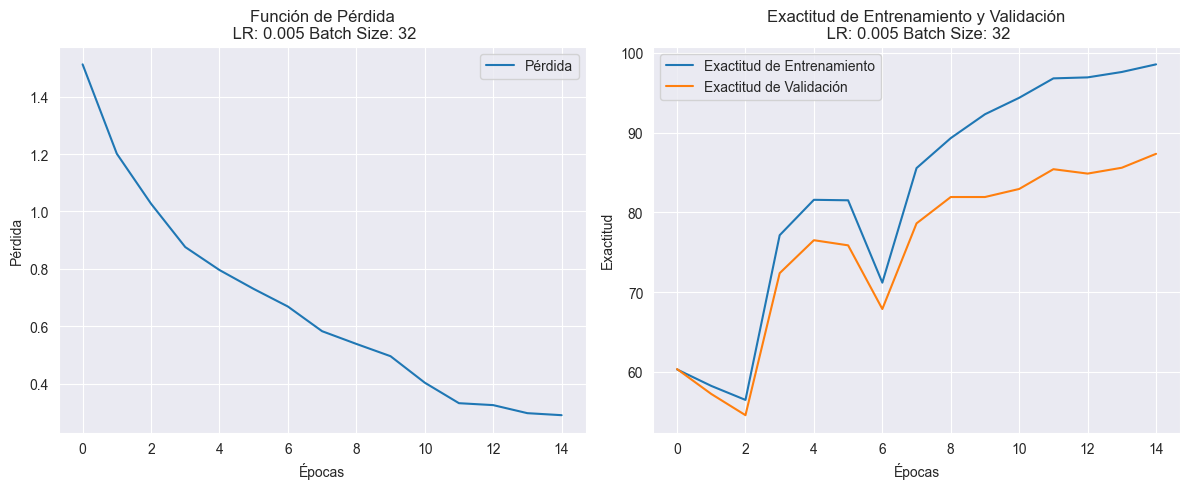


Entrenando con lr=0.005, batch_size=32, epochs=30
    Época 1, pérdida: 1.5011, exactitud entrenamiento: 29.36%, exactitud validación: 28.17%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.1529, exactitud entrenamiento: 65.96%, exactitud validación: 63.21%
Learning rate actual: 0.005000
    Época 3, pérdida: 0.9977, exactitud entrenamiento: 74.25%, exactitud validación: 70.37%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.8733, exactitud entrenamiento: 67.19%, exactitud validación: 64.50%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.7717, exactitud entrenamiento: 56.59%, exactitud validación: 54.95%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.7306, exactitud entrenamiento: 85.58%, exactitud validación: 78.07%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.6673, exactitud entrenamiento: 82.81%, exactitud validación: 75.41%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.6215, exactitud entrenamiento: 87.65%, exactitud validación: 78.

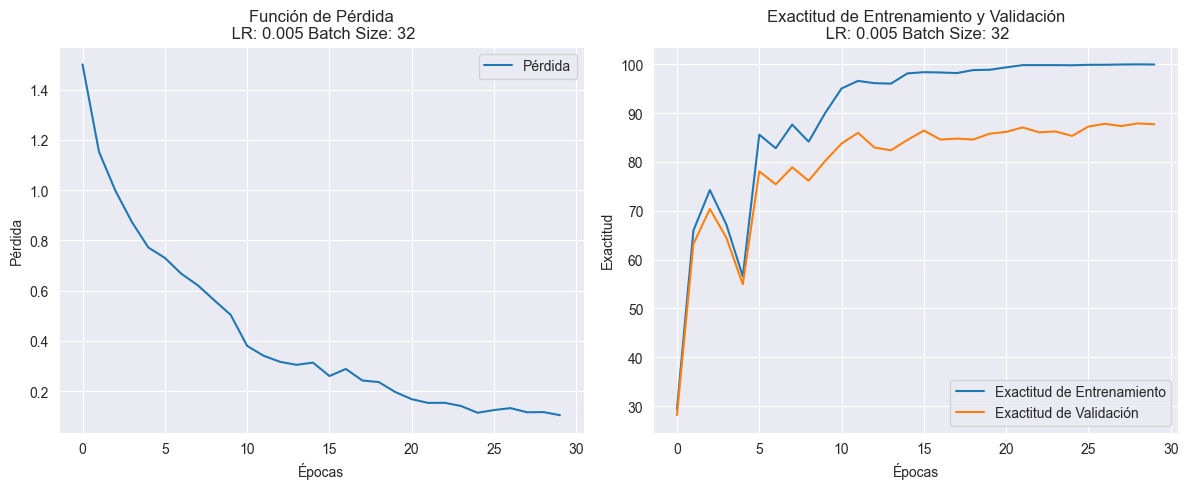


Entrenando con lr=0.005, batch_size=64, epochs=15
    Época 1, pérdida: 1.5519, exactitud entrenamiento: 52.46%, exactitud validación: 52.66%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.2075, exactitud entrenamiento: 45.53%, exactitud validación: 44.95%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.0071, exactitud entrenamiento: 73.57%, exactitud validación: 68.35%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.8881, exactitud entrenamiento: 77.63%, exactitud validación: 71.10%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.7917, exactitud entrenamiento: 77.39%, exactitud validación: 71.28%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.7013, exactitud entrenamiento: 84.38%, exactitud validación: 78.17%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.6134, exactitud entrenamiento: 83.21%, exactitud validación: 75.60%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.5357, exactitud entrenamiento: 86.35%, exactitud validación: 77.

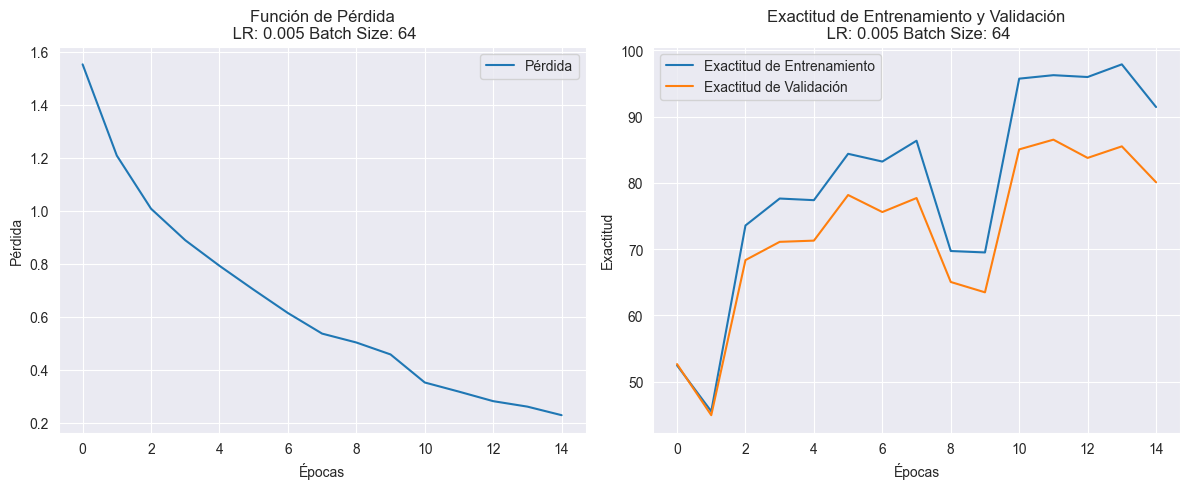


Entrenando con lr=0.005, batch_size=64, epochs=30
    Época 1, pérdida: 1.5268, exactitud entrenamiento: 23.17%, exactitud validación: 23.58%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.1574, exactitud entrenamiento: 36.88%, exactitud validación: 35.96%
Learning rate actual: 0.005000
    Época 3, pérdida: 0.9731, exactitud entrenamiento: 66.39%, exactitud validación: 62.94%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.8836, exactitud entrenamiento: 63.86%, exactitud validación: 60.73%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.7272, exactitud entrenamiento: 80.16%, exactitud validación: 75.32%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.6614, exactitud entrenamiento: 75.94%, exactitud validación: 71.74%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.5934, exactitud entrenamiento: 73.97%, exactitud validación: 66.15%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.5362, exactitud entrenamiento: 90.73%, exactitud validación: 82.

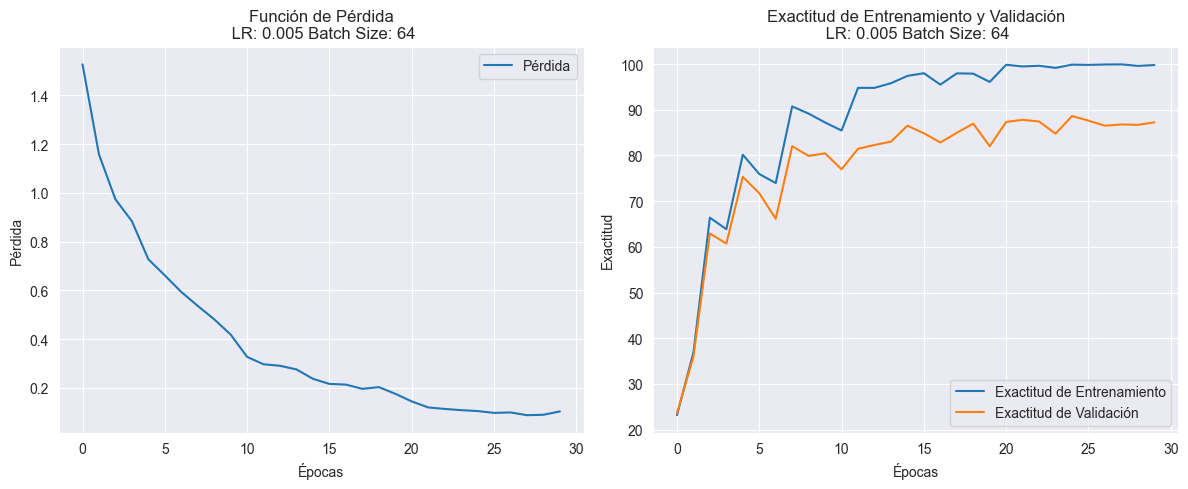


Entrenando con lr=0.001, batch_size=32, epochs=15
    Época 1, pérdida: 1.5301, exactitud entrenamiento: 21.66%, exactitud validación: 20.73%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.1031, exactitud entrenamiento: 60.10%, exactitud validación: 56.88%
Learning rate actual: 0.001000
    Época 3, pérdida: 0.9169, exactitud entrenamiento: 68.88%, exactitud validación: 64.86%
Learning rate actual: 0.001000
    Época 4, pérdida: 0.8256, exactitud entrenamiento: 65.96%, exactitud validación: 61.19%
Learning rate actual: 0.001000
    Época 5, pérdida: 0.7100, exactitud entrenamiento: 78.03%, exactitud validación: 74.77%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.6849, exactitud entrenamiento: 27.88%, exactitud validación: 24.50%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.5907, exactitud entrenamiento: 81.52%, exactitud validación: 75.78%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.5421, exactitud entrenamiento: 84.94%, exactitud validación: 77.

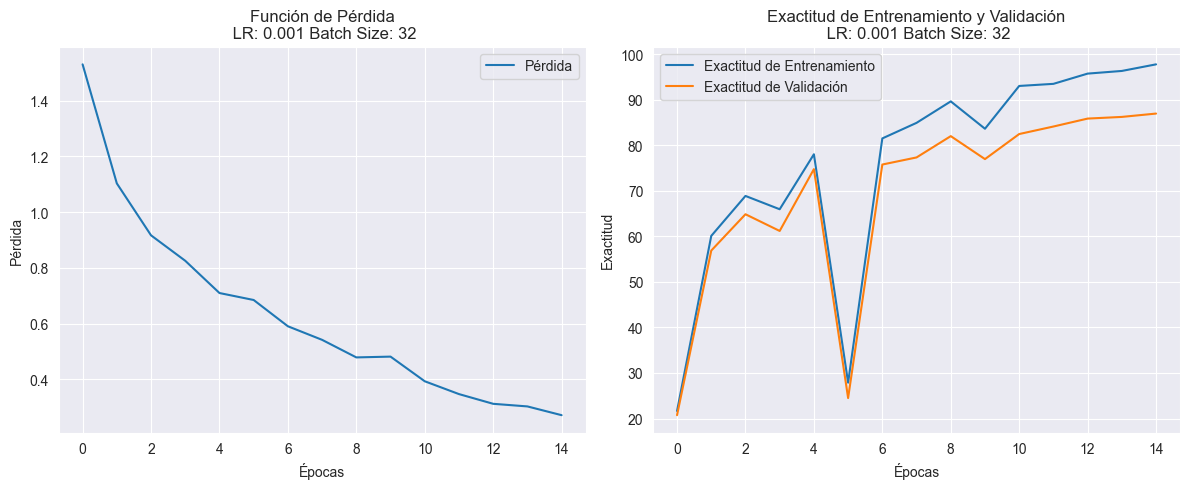


Entrenando con lr=0.001, batch_size=32, epochs=30
    Época 1, pérdida: 1.5466, exactitud entrenamiento: 62.63%, exactitud validación: 59.63%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.1155, exactitud entrenamiento: 48.03%, exactitud validación: 43.76%
Learning rate actual: 0.001000
    Época 3, pérdida: 0.9008, exactitud entrenamiento: 43.68%, exactitud validación: 40.73%
Learning rate actual: 0.001000
    Época 4, pérdida: 0.7852, exactitud entrenamiento: 75.57%, exactitud validación: 73.39%
Learning rate actual: 0.001000
    Época 5, pérdida: 0.7108, exactitud entrenamiento: 65.43%, exactitud validación: 62.84%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.6426, exactitud entrenamiento: 60.72%, exactitud validación: 58.99%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.6126, exactitud entrenamiento: 74.18%, exactitud validación: 68.62%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.5328, exactitud entrenamiento: 81.89%, exactitud validación: 75.

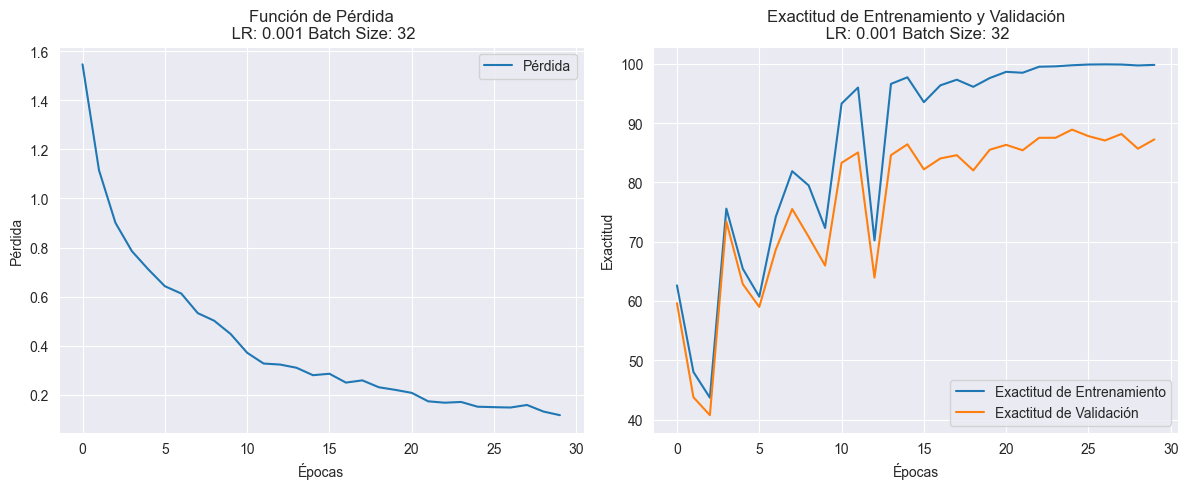


Entrenando con lr=0.001, batch_size=64, epochs=15
    Época 1, pérdida: 1.5669, exactitud entrenamiento: 21.50%, exactitud validación: 21.74%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.1485, exactitud entrenamiento: 56.07%, exactitud validación: 53.85%
Learning rate actual: 0.001000
    Época 3, pérdida: 0.9964, exactitud entrenamiento: 62.63%, exactitud validación: 60.55%
Learning rate actual: 0.001000
    Época 4, pérdida: 0.8623, exactitud entrenamiento: 69.59%, exactitud validación: 65.14%
Learning rate actual: 0.001000
    Época 5, pérdida: 0.7385, exactitud entrenamiento: 81.45%, exactitud validación: 76.51%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.6456, exactitud entrenamiento: 73.11%, exactitud validación: 68.72%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.6017, exactitud entrenamiento: 79.70%, exactitud validación: 74.13%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.4980, exactitud entrenamiento: 71.69%, exactitud validación: 67.

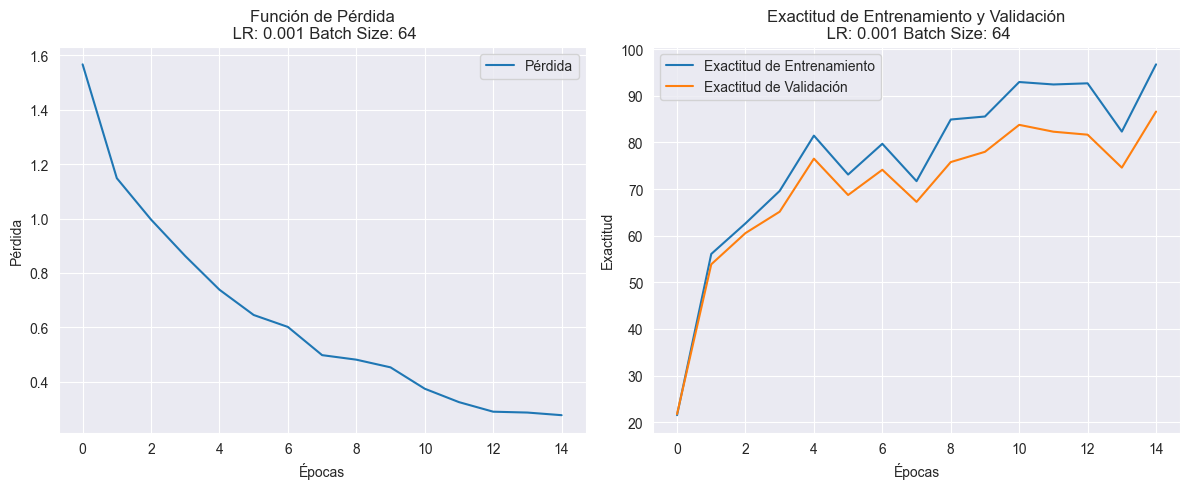


Entrenando con lr=0.001, batch_size=64, epochs=30
    Época 1, pérdida: 1.5616, exactitud entrenamiento: 24.49%, exactitud validación: 24.95%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.1571, exactitud entrenamiento: 53.64%, exactitud validación: 50.46%
Learning rate actual: 0.001000
    Época 3, pérdida: 0.9207, exactitud entrenamiento: 67.10%, exactitud validación: 66.06%
Learning rate actual: 0.001000
    Época 4, pérdida: 0.8376, exactitud entrenamiento: 76.31%, exactitud validación: 72.66%
Learning rate actual: 0.001000
    Época 5, pérdida: 0.7179, exactitud entrenamiento: 71.32%, exactitud validación: 66.97%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.6329, exactitud entrenamiento: 79.70%, exactitud validación: 74.04%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.5699, exactitud entrenamiento: 85.61%, exactitud validación: 79.08%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.5118, exactitud entrenamiento: 88.05%, exactitud validación: 81.

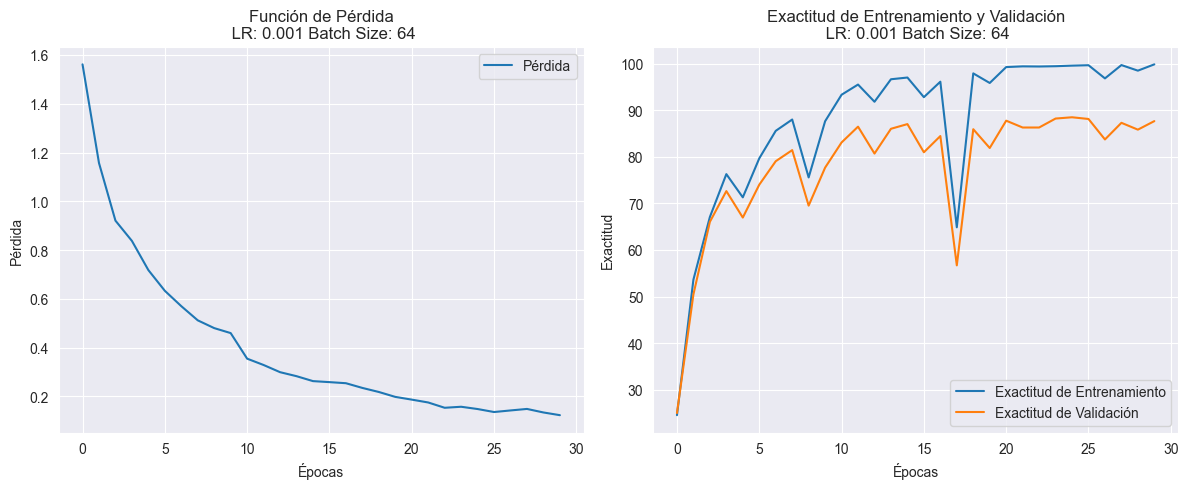


Entrenando con lr=0.0005, batch_size=32, epochs=15
    Época 1, pérdida: 1.6075, exactitud entrenamiento: 29.61%, exactitud validación: 28.44%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.2085, exactitud entrenamiento: 60.87%, exactitud validación: 56.51%
Learning rate actual: 0.000500
    Época 3, pérdida: 0.9722, exactitud entrenamiento: 39.53%, exactitud validación: 38.99%
Learning rate actual: 0.000500
    Época 4, pérdida: 0.8740, exactitud entrenamiento: 67.96%, exactitud validación: 62.29%
Learning rate actual: 0.000500
    Época 5, pérdida: 0.7433, exactitud entrenamiento: 35.37%, exactitud validación: 34.22%
Learning rate actual: 0.000500
    Época 6, pérdida: 0.6666, exactitud entrenamiento: 59.98%, exactitud validación: 56.42%
Learning rate actual: 0.000500
    Época 7, pérdida: 0.6235, exactitud entrenamiento: 82.81%, exactitud validación: 77.34%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.5679, exactitud entrenamiento: 80.16%, exactitud validación: 75

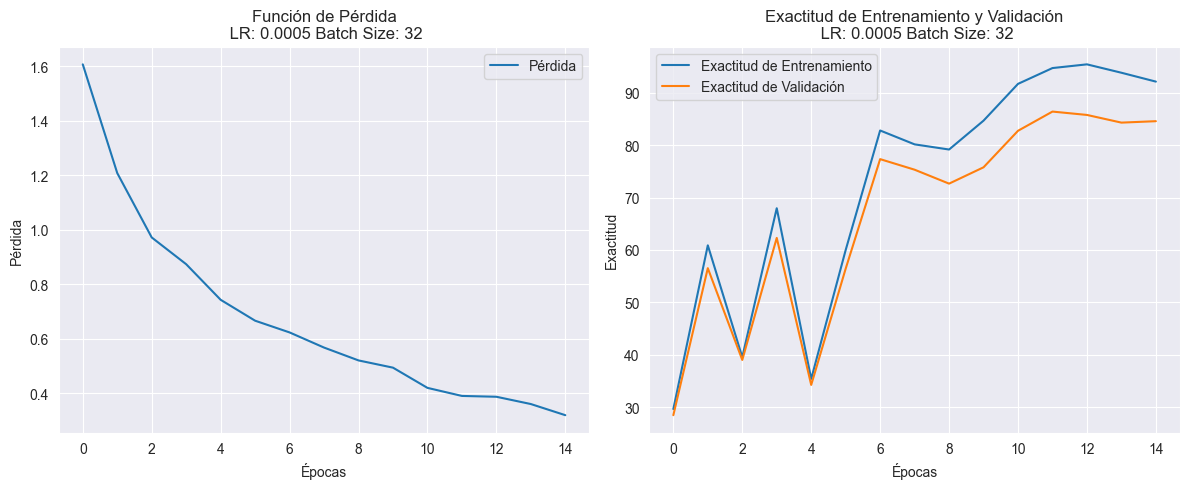


Entrenando con lr=0.0005, batch_size=32, epochs=30
    Época 1, pérdida: 1.5913, exactitud entrenamiento: 28.40%, exactitud validación: 28.44%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.2189, exactitud entrenamiento: 55.42%, exactitud validación: 53.21%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.0182, exactitud entrenamiento: 65.34%, exactitud validación: 62.11%
Learning rate actual: 0.000500
    Época 4, pérdida: 0.8982, exactitud entrenamiento: 67.41%, exactitud validación: 64.31%
Learning rate actual: 0.000500
    Época 5, pérdida: 0.7838, exactitud entrenamiento: 67.56%, exactitud validación: 64.22%
Learning rate actual: 0.000500
    Época 6, pérdida: 0.7146, exactitud entrenamiento: 76.28%, exactitud validación: 72.84%
Learning rate actual: 0.000500
    Época 7, pérdida: 0.6273, exactitud entrenamiento: 83.36%, exactitud validación: 78.17%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.5861, exactitud entrenamiento: 84.13%, exactitud validación: 78

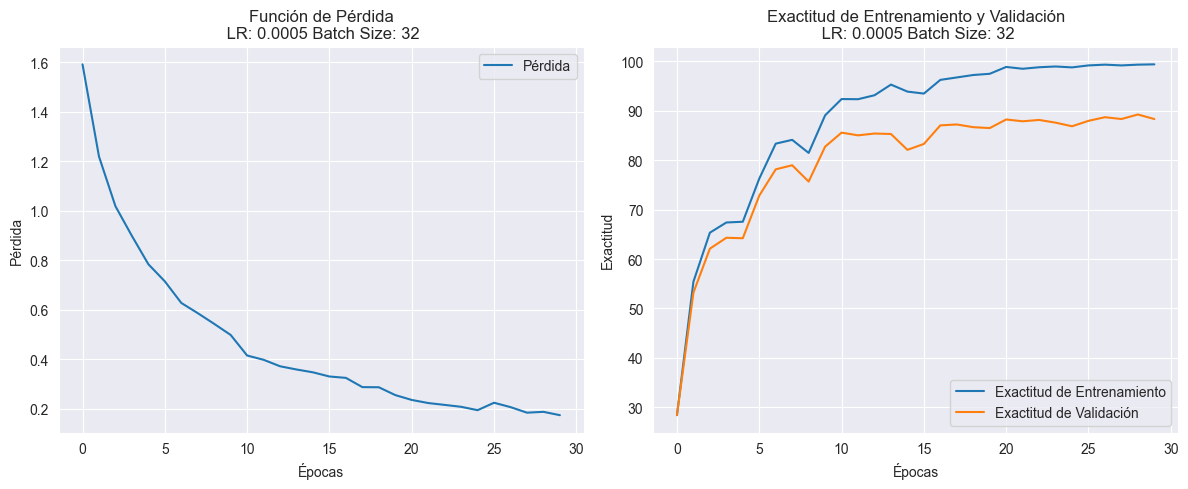


Entrenando con lr=0.0005, batch_size=64, epochs=15
    Época 1, pérdida: 1.6550, exactitud entrenamiento: 17.41%, exactitud validación: 17.71%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.3018, exactitud entrenamiento: 34.72%, exactitud validación: 33.12%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.1241, exactitud entrenamiento: 43.56%, exactitud validación: 41.38%
Learning rate actual: 0.000500
    Época 4, pérdida: 0.9690, exactitud entrenamiento: 47.20%, exactitud validación: 45.23%
Learning rate actual: 0.000500
    Época 5, pérdida: 0.8632, exactitud entrenamiento: 71.53%, exactitud validación: 69.27%
Learning rate actual: 0.000500
    Época 6, pérdida: 0.7668, exactitud entrenamiento: 71.41%, exactitud validación: 68.07%
Learning rate actual: 0.000500
    Época 7, pérdida: 0.6807, exactitud entrenamiento: 71.60%, exactitud validación: 68.62%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.6217, exactitud entrenamiento: 69.04%, exactitud validación: 65

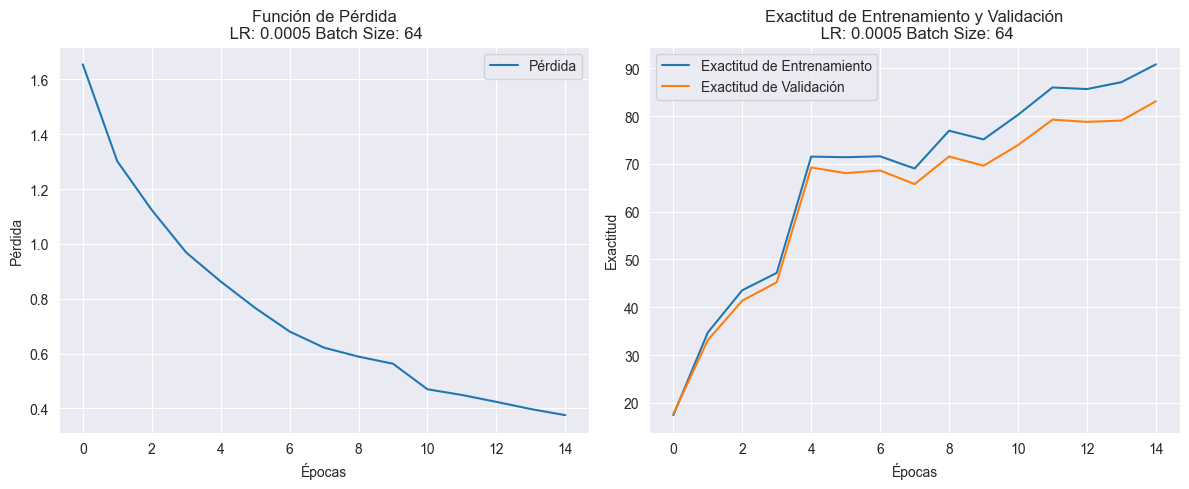


Entrenando con lr=0.0005, batch_size=64, epochs=30
    Época 1, pérdida: 1.6518, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.2663, exactitud entrenamiento: 27.08%, exactitud validación: 27.25%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.1006, exactitud entrenamiento: 54.74%, exactitud validación: 51.83%
Learning rate actual: 0.000500
    Época 4, pérdida: 0.9558, exactitud entrenamiento: 45.81%, exactitud validación: 44.59%
Learning rate actual: 0.000500
    Época 5, pérdida: 0.8428, exactitud entrenamiento: 51.48%, exactitud validación: 50.00%
Learning rate actual: 0.000500
    Época 6, pérdida: 0.7861, exactitud entrenamiento: 73.01%, exactitud validación: 70.37%
Learning rate actual: 0.000500
    Época 7, pérdida: 0.7091, exactitud entrenamiento: 66.11%, exactitud validación: 63.39%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.6454, exactitud entrenamiento: 80.53%, exactitud validación: 73

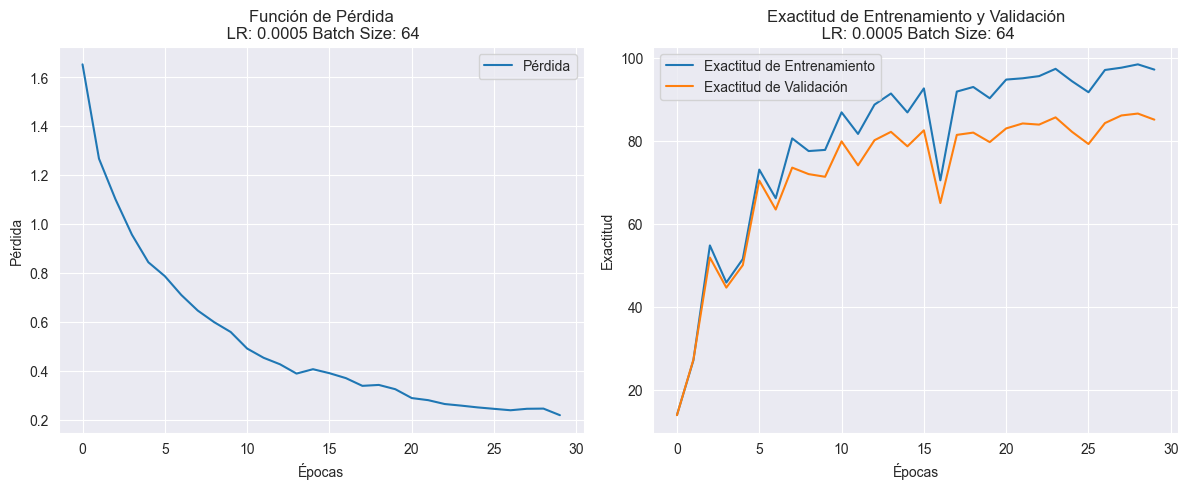


Entrenando con lr=0.0001, batch_size=32, epochs=15
    Época 1, pérdida: 1.8310, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.6006, exactitud entrenamiento: 15.22%, exactitud validación: 15.32%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.4724, exactitud entrenamiento: 21.63%, exactitud validación: 21.93%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.3546, exactitud entrenamiento: 27.76%, exactitud validación: 27.98%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.2418, exactitud entrenamiento: 29.39%, exactitud validación: 30.00%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.1707, exactitud entrenamiento: 33.89%, exactitud validación: 33.94%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.0978, exactitud entrenamiento: 36.20%, exactitud validación: 36.15%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.0283, exactitud entrenamiento: 27.14%, exactitud validación: 27

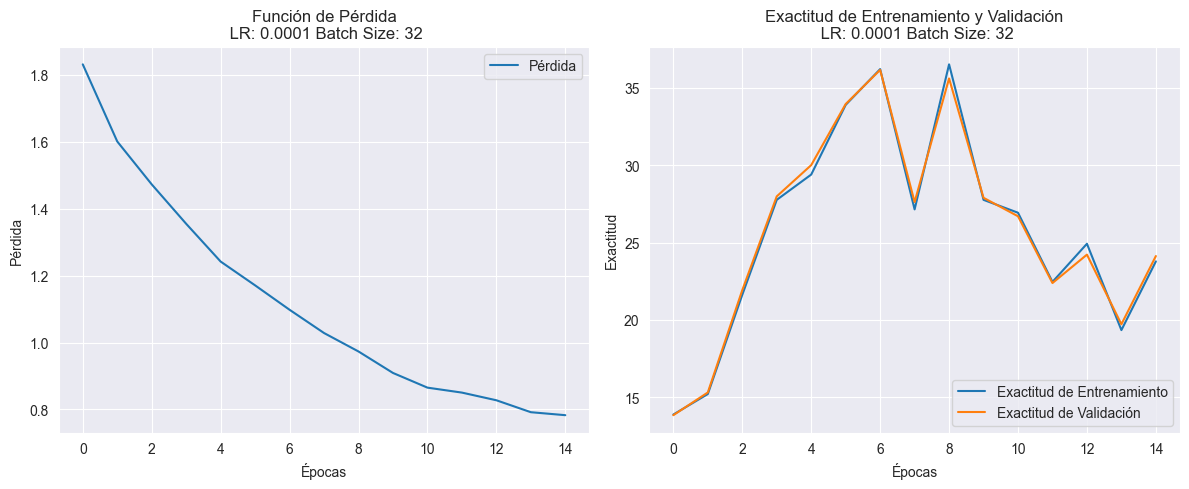


Entrenando con lr=0.0001, batch_size=32, epochs=30
    Época 1, pérdida: 1.8189, exactitud entrenamiento: 14.63%, exactitud validación: 14.40%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.5907, exactitud entrenamiento: 16.97%, exactitud validación: 17.16%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.4478, exactitud entrenamiento: 22.89%, exactitud validación: 23.39%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.3238, exactitud entrenamiento: 32.84%, exactitud validación: 31.38%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.2368, exactitud entrenamiento: 36.29%, exactitud validación: 34.40%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.1744, exactitud entrenamiento: 40.26%, exactitud validación: 37.89%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.1198, exactitud entrenamiento: 50.34%, exactitud validación: 46.97%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.0641, exactitud entrenamiento: 49.08%, exactitud validación: 45

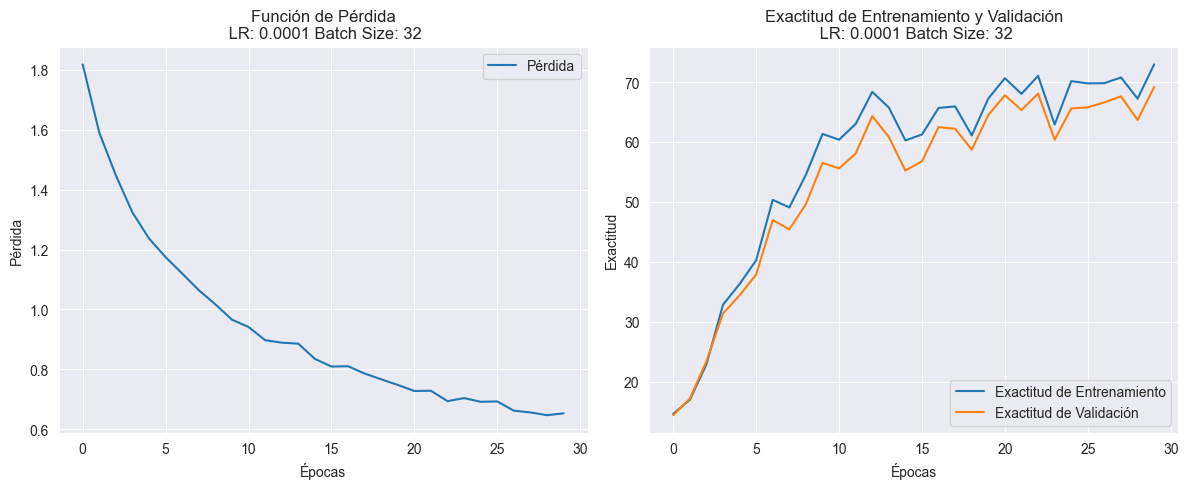


Entrenando con lr=0.0001, batch_size=64, epochs=15
    Época 1, pérdida: 1.8917, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.6635, exactitud entrenamiento: 15.25%, exactitud validación: 15.14%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.5056, exactitud entrenamiento: 22.67%, exactitud validación: 22.84%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.3969, exactitud entrenamiento: 22.40%, exactitud validación: 22.39%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.2924, exactitud entrenamiento: 28.07%, exactitud validación: 27.43%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.2046, exactitud entrenamiento: 32.78%, exactitud validación: 32.02%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.1418, exactitud entrenamiento: 37.52%, exactitud validación: 36.70%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.0835, exactitud entrenamiento: 39.83%, exactitud validación: 38

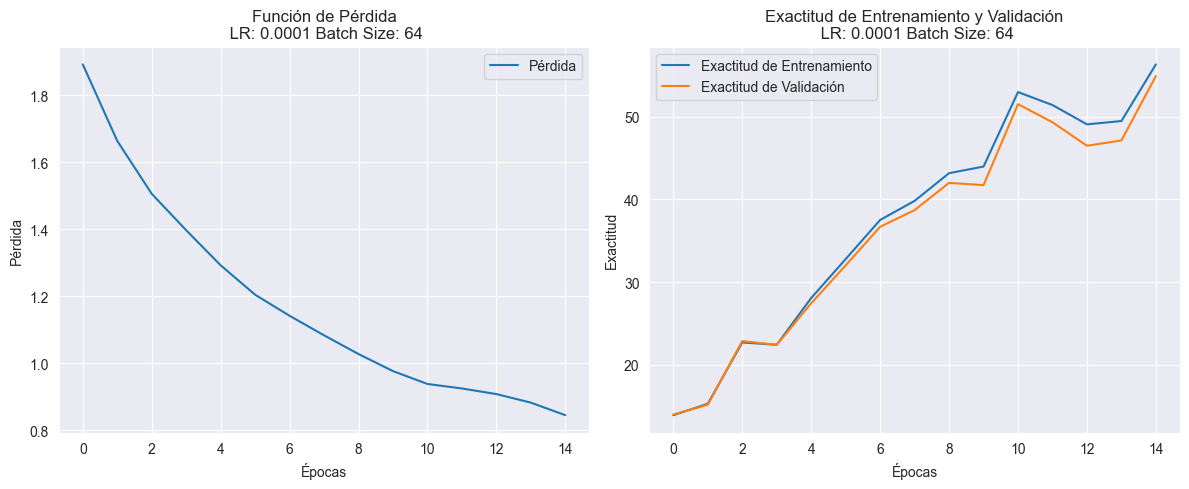


Entrenando con lr=0.0001, batch_size=64, epochs=30
    Época 1, pérdida: 1.8681, exactitud entrenamiento: 15.87%, exactitud validación: 14.68%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.6627, exactitud entrenamiento: 18.33%, exactitud validación: 18.17%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.5435, exactitud entrenamiento: 21.44%, exactitud validación: 21.10%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.4482, exactitud entrenamiento: 24.28%, exactitud validación: 23.85%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.3439, exactitud entrenamiento: 27.57%, exactitud validación: 27.98%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.2724, exactitud entrenamiento: 38.51%, exactitud validación: 36.15%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.2019, exactitud entrenamiento: 40.48%, exactitud validación: 38.17%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.1217, exactitud entrenamiento: 38.35%, exactitud validación: 36

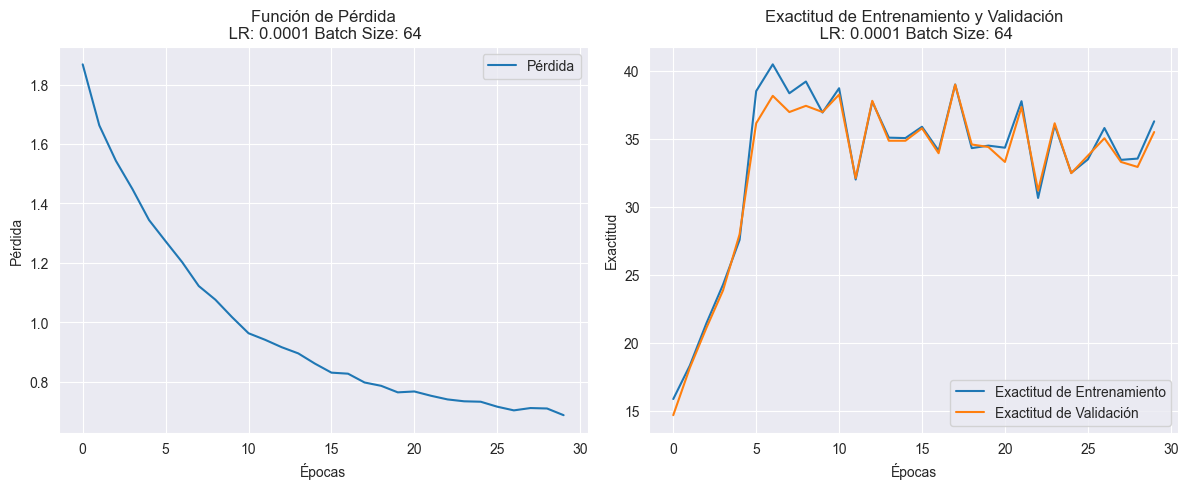


Entrenando con lr=5e-05, batch_size=32, epochs=15
    Época 1, pérdida: 1.9468, exactitud entrenamiento: 20.55%, exactitud validación: 21.65%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.7628, exactitud entrenamiento: 17.31%, exactitud validación: 16.79%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.6528, exactitud entrenamiento: 20.15%, exactitud validación: 20.92%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.5663, exactitud entrenamiento: 25.75%, exactitud validación: 27.43%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.4833, exactitud entrenamiento: 29.57%, exactitud validación: 30.00%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.4194, exactitud entrenamiento: 32.62%, exactitud validación: 32.75%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.3800, exactitud entrenamiento: 32.50%, exactitud validación: 31.74%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.3072, exactitud entrenamiento: 40.51%, exactitud validación: 40.

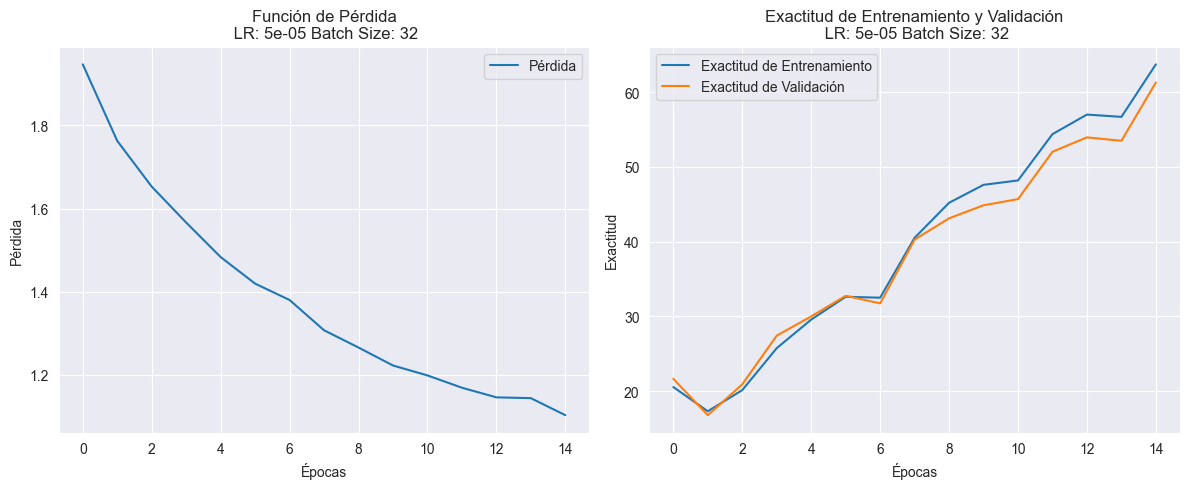


Entrenando con lr=5e-05, batch_size=32, epochs=30
    Época 1, pérdida: 1.9599, exactitud entrenamiento: 14.11%, exactitud validación: 13.94%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.7537, exactitud entrenamiento: 15.34%, exactitud validación: 15.05%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.6576, exactitud entrenamiento: 18.70%, exactitud validación: 18.44%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.5444, exactitud entrenamiento: 25.57%, exactitud validación: 24.68%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.4837, exactitud entrenamiento: 32.13%, exactitud validación: 32.48%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.4121, exactitud entrenamiento: 34.63%, exactitud validación: 33.94%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.3542, exactitud entrenamiento: 37.00%, exactitud validación: 36.51%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.2823, exactitud entrenamiento: 38.08%, exactitud validación: 37.

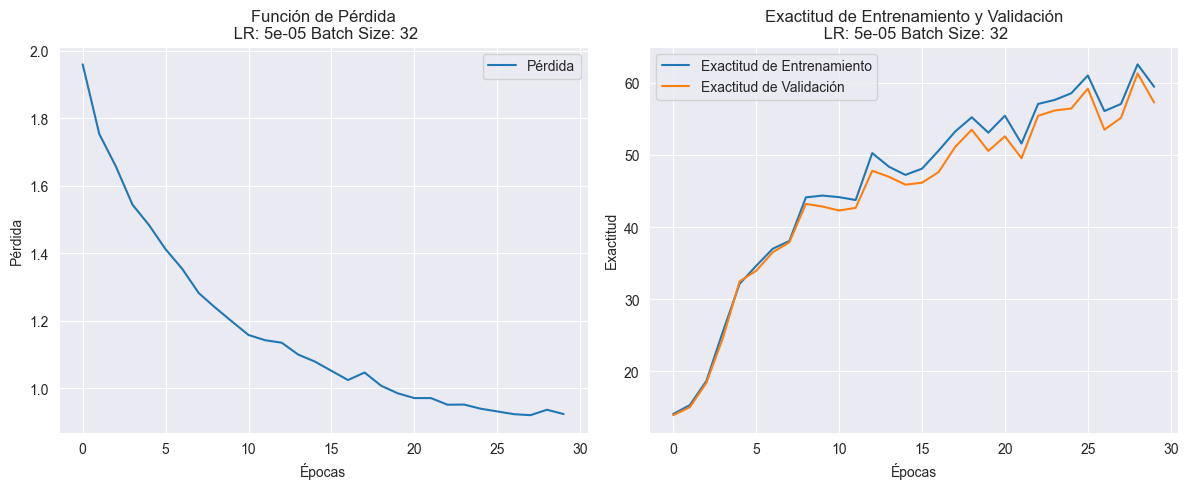


Entrenando con lr=5e-05, batch_size=64, epochs=15
    Época 1, pérdida: 1.9895, exactitud entrenamiento: 15.47%, exactitud validación: 15.87%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.8415, exactitud entrenamiento: 19.62%, exactitud validación: 19.08%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.7289, exactitud entrenamiento: 17.84%, exactitud validación: 17.34%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.6301, exactitud entrenamiento: 21.13%, exactitud validación: 21.56%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.5611, exactitud entrenamiento: 24.61%, exactitud validación: 24.59%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.5238, exactitud entrenamiento: 25.85%, exactitud validación: 25.87%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.4448, exactitud entrenamiento: 27.23%, exactitud validación: 27.89%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.4041, exactitud entrenamiento: 32.78%, exactitud validación: 32.

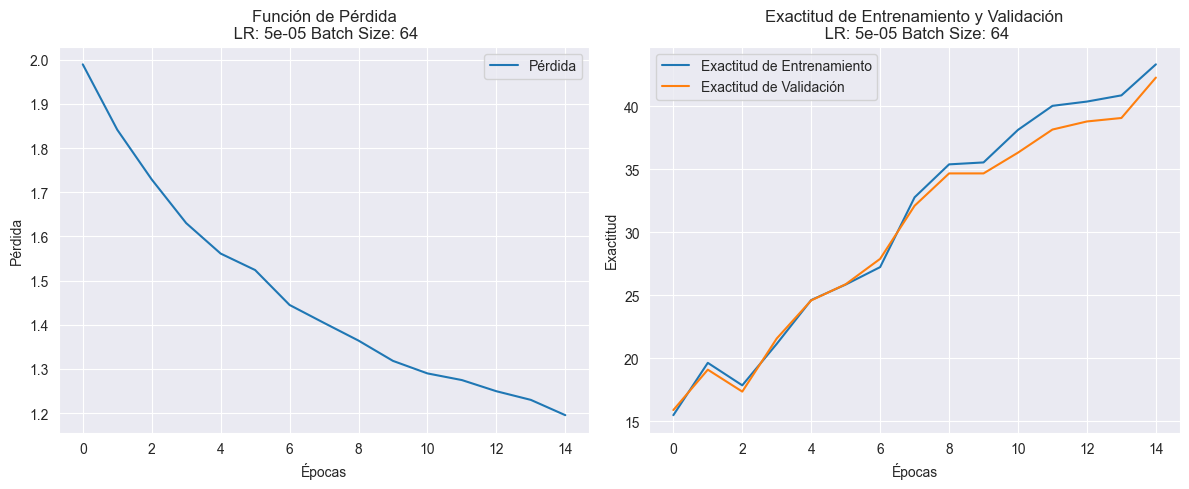


Entrenando con lr=5e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0177, exactitud entrenamiento: 16.17%, exactitud validación: 16.15%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.8316, exactitud entrenamiento: 18.30%, exactitud validación: 18.62%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.7358, exactitud entrenamiento: 15.68%, exactitud validación: 15.60%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.6482, exactitud entrenamiento: 16.82%, exactitud validación: 16.42%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.5696, exactitud entrenamiento: 16.94%, exactitud validación: 16.33%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.4960, exactitud entrenamiento: 17.68%, exactitud validación: 17.06%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.4489, exactitud entrenamiento: 20.43%, exactitud validación: 20.09%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.4007, exactitud entrenamiento: 20.15%, exactitud validación: 20.

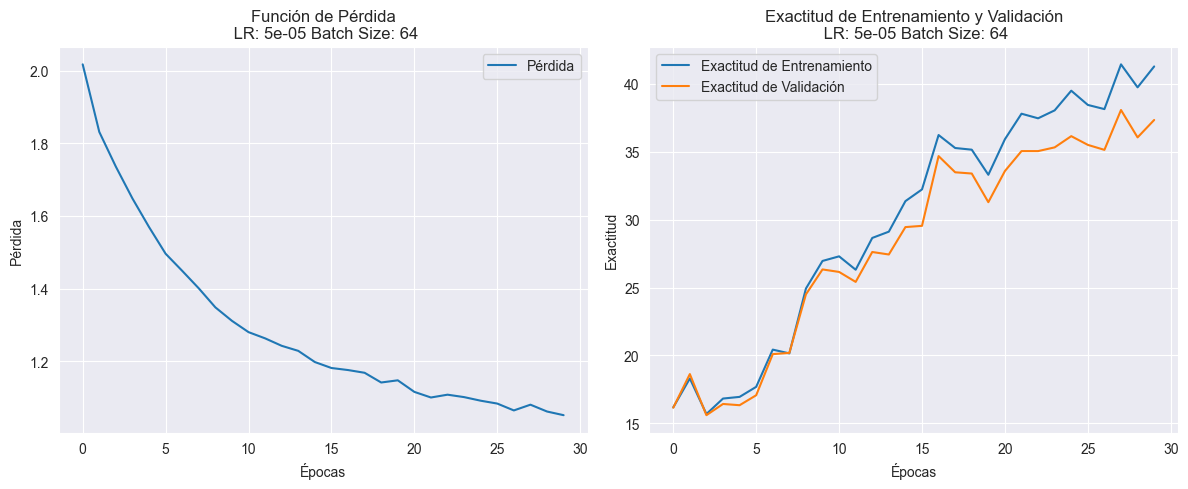


Entrenando con lr=1e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0951, exactitud entrenamiento: 15.83%, exactitud validación: 17.25%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0186, exactitud entrenamiento: 15.56%, exactitud validación: 14.95%
Learning rate actual: 0.000010
    Época 3, pérdida: 1.9518, exactitud entrenamiento: 18.08%, exactitud validación: 15.32%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.8926, exactitud entrenamiento: 16.20%, exactitud validación: 15.60%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.8512, exactitud entrenamiento: 15.65%, exactitud validación: 14.77%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.8239, exactitud entrenamiento: 16.14%, exactitud validación: 15.41%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.7810, exactitud entrenamiento: 16.57%, exactitud validación: 15.87%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.7296, exactitud entrenamiento: 16.88%, exactitud validación: 15.

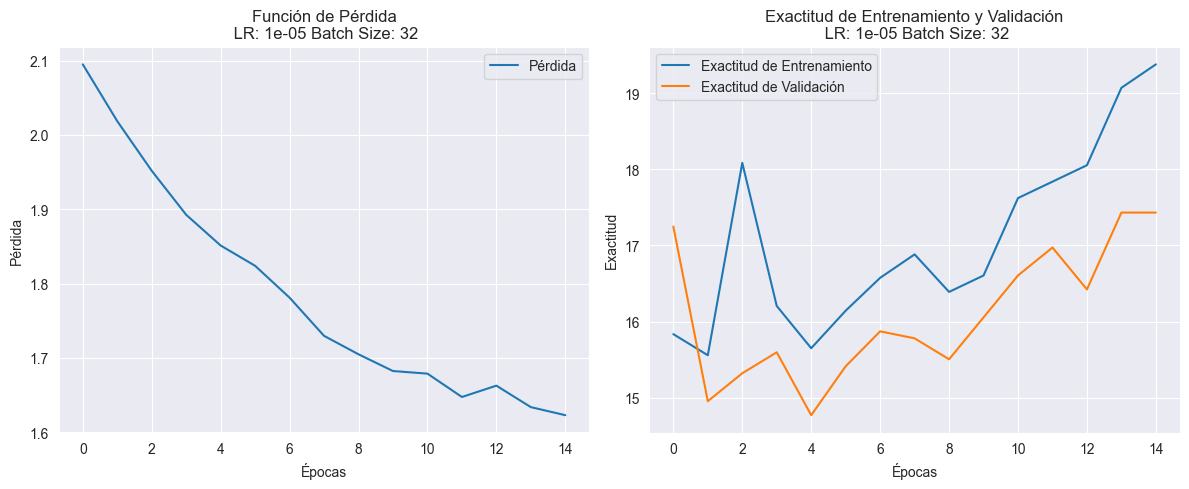


Entrenando con lr=1e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0278, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 2, pérdida: 1.9328, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 3, pérdida: 1.8639, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.8352, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.8064, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.7725, exactitud entrenamiento: 13.96%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.7490, exactitud entrenamiento: 14.02%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.7116, exactitud entrenamiento: 14.05%, exactitud validación: 14.

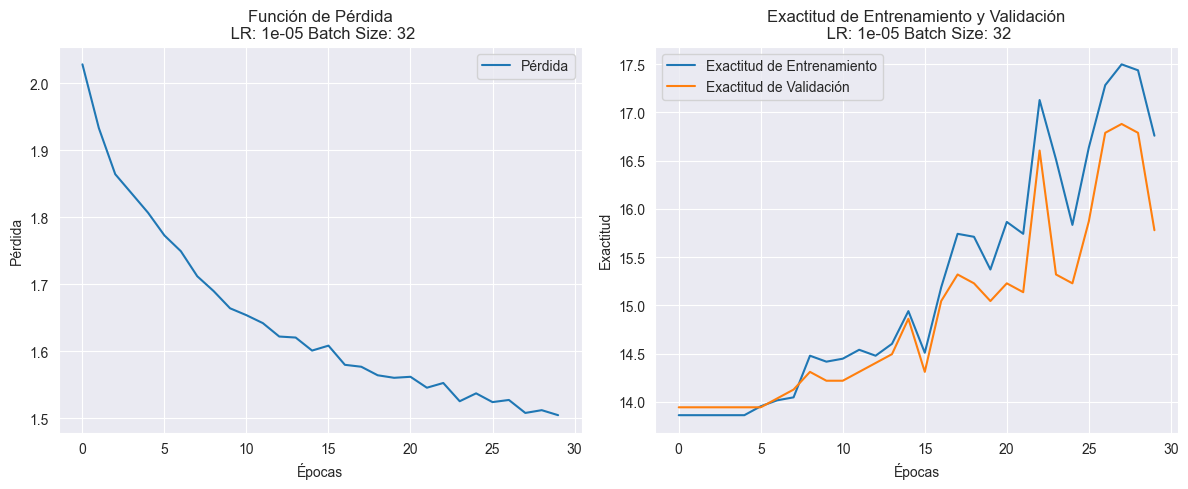


Entrenando con lr=1e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0690, exactitud entrenamiento: 15.40%, exactitud validación: 15.05%
Learning rate actual: 0.000010
    Época 2, pérdida: 1.9884, exactitud entrenamiento: 13.92%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 3, pérdida: 1.9556, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.9094, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.8765, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.8371, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.8030, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.7831, exactitud entrenamiento: 13.86%, exactitud validación: 13.

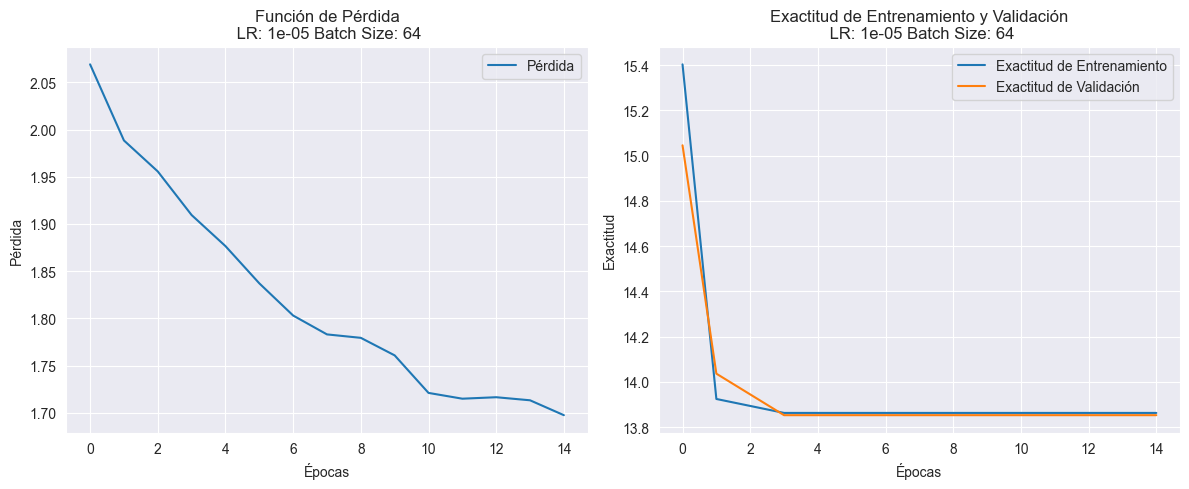


Entrenando con lr=1e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0663, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0062, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 3, pérdida: 1.9615, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.9181, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.8833, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.8476, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.8205, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.7940, exactitud entrenamiento: 13.89%, exactitud validación: 13.

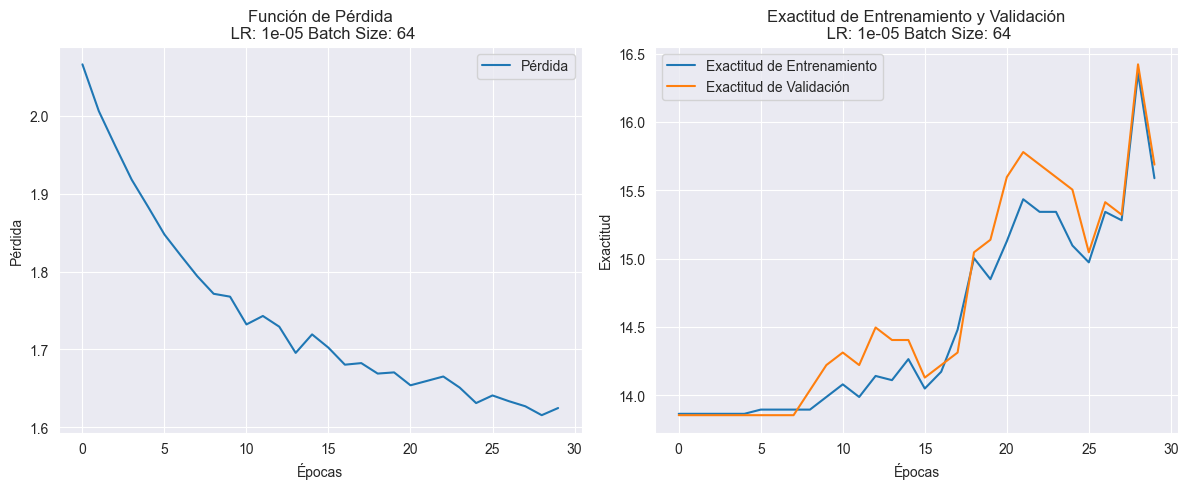

In [9]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from itertools import product

learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batch_sizes = [32, 64]
epochs_list = [15, 30]

resultados = []
modelos = {}

for lr, batch_size, epochs in product(learning_rates, batch_sizes, epochs_list):

    # Crear DataLoaders para los datos de entrenamiento, validación y test
    dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True)
    dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelo = ConvNet().to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=lr)
    scheduler = StepLR(optimizador, step_size=10, gamma=0.5)

    combinacion = (lr, batch_size, epochs)
    print(f"\nEntrenando con lr={lr}, batch_size={batch_size}, epochs={epochs}")

    modelos[combinacion] = modelo

    valores_perdida = []
    exactitud_entrenamiento = []
    exactitud_validacion = []

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoca in range(epochs):
        modelos[combinacion].train()
        running_loss = 0.0
        for images, labels in dataloader_entrenamiento:
            images, labels = images.to(device), labels.to(device)
            outputs = modelos[combinacion](images)
            loss = criterio(outputs, labels)
            loss.backward()
            optimizador.step()
            optimizador.zero_grad()
            running_loss += loss.item()

        valores_perdida.append(running_loss / len(dataloader_entrenamiento))

        with torch.no_grad():
            modelos[combinacion].eval()

            # Calcular exactitud de entrenamiento
            correctas = 0
            total = 0
            for images, labels in dataloader_entrenamiento:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_entrenamiento.append(100 * correctas / total)

            # Calcular exactitud de validación
            correctas = 0
            total = 0
            for images, labels in dataloader_validacion:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_validacion.append(100 * correctas / total)
        
        scheduler.step()
        
        # Early stopping
        val_loss = valores_perdida[-1]  # Usamos la pérdida más reciente
        early_stopping(val_loss, modelo)

        # Verifica si se activa la parada anticipada
        if early_stopping.early_stop:
            print("Parada anticipada activada")
            modelo.load_state_dict(early_stopping.best_model_wts)  # Cargar los mejores pesos
            break

        # Imprimir métricas de la época
        print(f'    Época {epoca+1}, pérdida: {val_loss:.4f}, exactitud entrenamiento: {exactitud_entrenamiento[-1]:.2f}%, exactitud validación: {exactitud_validacion[-1]:.2f}%')
        
        for param_group in optimizador.param_groups:
            print(f"Learning rate actual: {param_group['lr']:.6f}")

    graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion)
    resultados.append((lr, batch_size, epochs, exactitud_validacion[-1]))


Top configuraciones:
    LR=0.0005, Batch=32, Epochs=30, Exactitud validación=88.35%
    LR=0.005, Batch=32, Epochs=30, Exactitud validación=87.71%
    LR=0.001, Batch=64, Epochs=30, Exactitud validación=87.71%
    LR=0.005, Batch=32, Epochs=15, Exactitud validación=87.34%
    LR=0.005, Batch=64, Epochs=30, Exactitud validación=87.25%

Exactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR=0.0005, Batch=32, Epochs=30    : 87.20%
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9308    0.8121    0.8674       149
           1     0.9423    0.9671    0.9545       152
           2     0.8483    0.8255    0.8367       149
           3     0.8773    0.8266    0.8512       173
           4     0.7933    0.9467    0.8632       150
           5     0.8500    0.7987    0.8235       149
           6     0.8788    0.9295    0.9034       156

    accuracy                         0.8720      1078
   macro avg     0.8744   

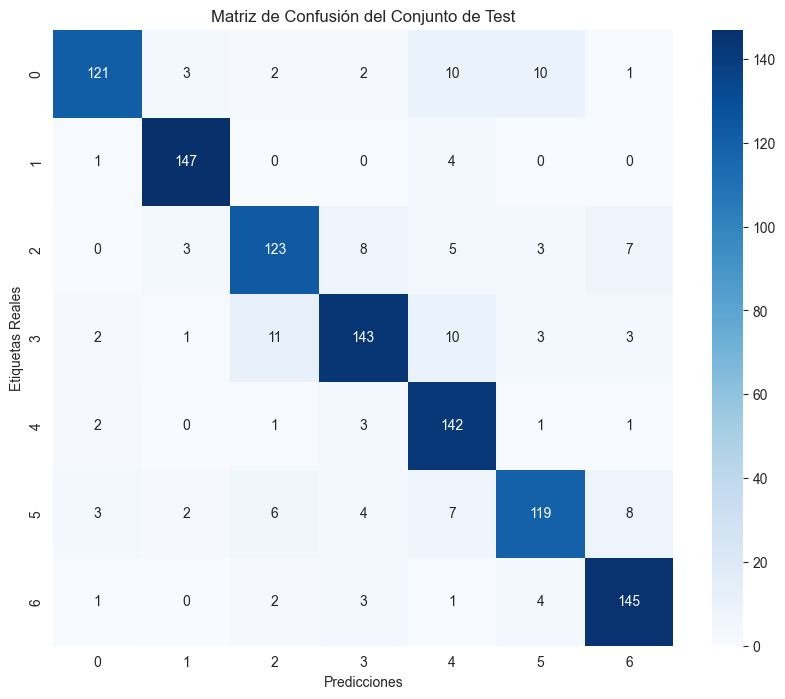

Clases presentes en el conjunto de test: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [10]:
mejores_resultados = sorted(resultados, key=lambda x: x[3], reverse=True)
print("Top configuraciones:")
for res in mejores_resultados[:5]:
    print(f"    LR={res[0]}, Batch={res[1]}, Epochs={res[2]}, Exactitud validación={res[3]:.2f}%")

mejor = (mejores_resultados[0][0], mejores_resultados[0][1], mejores_resultados[0][2])
modelo = modelos[mejor]
exactitud_test = calcular_exactitud_test(modelo, dataloader_test, device)
print(f"\nExactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR={mejor[0]}, Batch={mejor[1]}, Epochs={mejor[2]}    : {exactitud_test:.2f}%")
matriz_de_confusion(modelo, dataloader_test, device)